# Initial Analysis on Cancer Waiting Times in Scotland

Prepared by C.A.Oldnall

## Set-Up

Below I have created a function which takes in a region code, cancer type and a splitting quarter (which is useful for when trying to look at the affect of COVID). This will then return x and y which are the quarter-eligible pairing pre splitting quarter and then a and b are the corresponding pair for after the splitting pair.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.api import qqplot
import changefinder
import ruptures as rpt

fullData = pd.read_csv("/home/s2227580/Documents/PHS Project/31DayData.csv")
myData = fullData[['Quarter', 'HB', 'CancerType','NumberOfEligibleReferrals31DayStandard','NumberOfEligibleReferralsTreatedWithin31Days']]

In [18]:
def ReigonTypeQuarterSelector(reigonCode, cancerType, quarterSplit):
    typeData = myData[myData['CancerType']== cancerType]
    reigonalData = typeData[typeData['HB'] == reigonCode]
    
    aggregation_functions = {'Quarter':'first', 'HB': 'first', 'CancerType': 'first', 'NumberOfEligibleReferrals31DayStandard': 'sum', 'NumberOfEligibleReferralsTreatedWithin31Days': 'sum'}
    reigonalData = reigonalData.groupby(reigonalData['Quarter'], as_index=False).aggregate(aggregation_functions)
        
    Qs = reigonalData.iloc[:,[0]]
    QsReset = Qs.reset_index()
    Index = min(QsReset.index[QsReset['Quarter'] == quarterSplit].tolist())
    
    PreQ = reigonalData.iloc[:Index,:]
    PostQ = reigonalData.iloc[Index:,:]
    
    x = PreQ["Quarter"]
    y = PreQ["NumberOfEligibleReferrals31DayStandard"]
    a = PostQ["Quarter"]
    b = PostQ["NumberOfEligibleReferrals31DayStandard"]
    
    return x, y, a, b

Some useful notes on the formatting and selection of data:

$\textbf{reigonCode}$:

Format should be given as: 'S080000NN'

Input 'NN' is from the set, $\{ 15, 16, 17, 19, 20, 22, 24, 25, 26, 28, 29, 30, 31, 32 \}$.


$\textbf{cancerType}$:

Format should be given as: 'Cancer Type'

Input is from the set; 

'Cervical', 'Lymphoma', 'Melanoma', 'Ovarian', 'Head & Neck', 'Breast', 'Colorectal', 'Upper GI', 'Urological', 'Lung', 'All Cancer Types'.

$\textbf{quarterSplit}$:

Format should be given as: 'YYYYQN' (eg. '2019Q3')

Input is from '2012Q1' upto '2021Q3'. Pick the quarter from which you want to split $\textbf{UPTO}$.

------------------------------------
## Graphing Reigons

Below we have a some code and a plot which shows us how each reigon's cancer cases (for all cancer types combined) have developed over time. We create a break at the second quarter of 2020 to mark the start of the pandemic. 

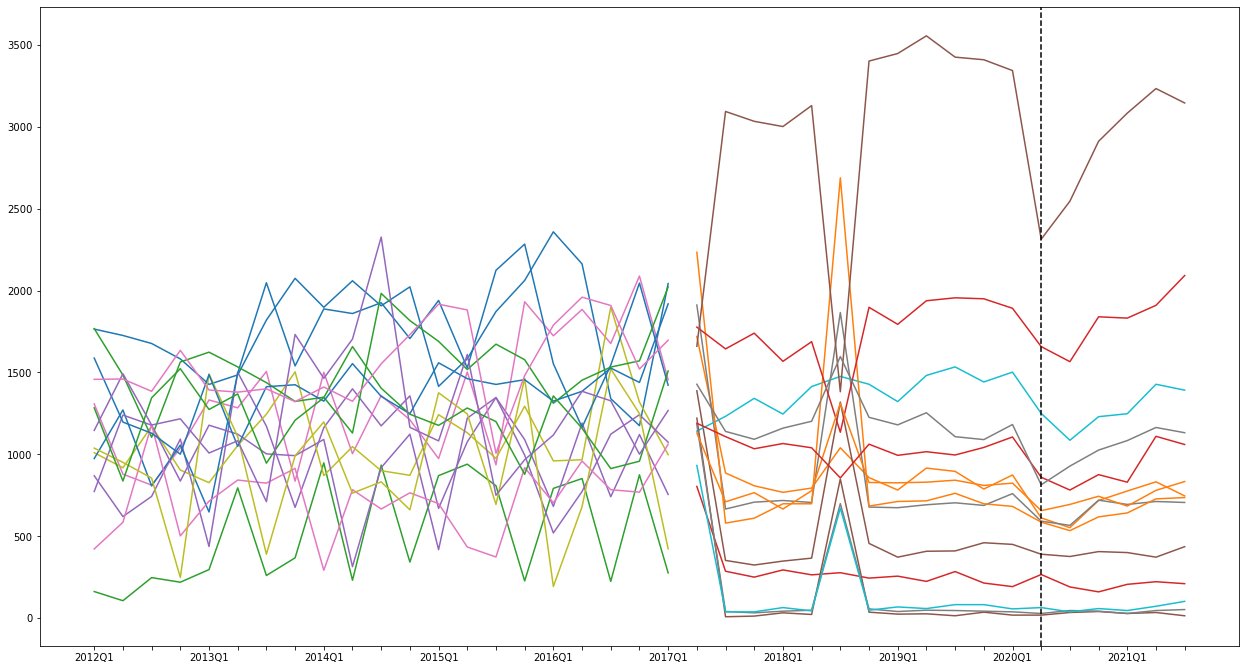

In [22]:
Reigons = ['S08000015', 'S08000016', 'S08000017', 'S08000019', 'S08000020', 'S08000022', 'S08000024', 'S08000025', 'S08000026', 'S08000028', 'S08000029', 'S08000030', 'S08000031', 'S08000032']

fig, d1 = plt.subplots(1, 1, sharey=True)

for i in Reigons:
    x, y, a, b = ReigonTypeQuarterSelector(i, 'All Cancer Types', '2017Q2')
    d1.plot(x, y)
    d1.plot(a, b)

every_nth = 4
for n, label in enumerate(d1.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

plt.axvline(x='2020Q2', color='k', linestyle='--')

fig.set_size_inches(18.5, 10.5, forward=True)
fig.tight_layout(pad=5.0) 
plt.show()

---------------------------------------------------
## Goals for Tomorrow:

- Run regression analysis on the above to see whether we can create a linear model (GLM?)
- See whether we can get time series to fit it...maybe an ARIMA model?

----------------------------------------
## Linear Regression

The goal of the below is to try and see whether we can correlate the patterns between the pre-covid and post-covid years. If we have a high regression coefficient then this may suggest that we can in future model using non-affected data.

coefficient of determination: 0.21454704866975982
intercept: 1132.2994652406417
slope: [-18.62667112]
predicted response:
[1132.29946524 1113.67279412 1095.04612299 1076.41945187 1057.79278075
 1039.16610963 1020.5394385  1001.91276738  983.28609626  964.65942513
  946.03275401  927.40608289  908.77941176  890.15274064  871.52606952
  852.8993984   834.27272727  815.64605615  797.01938503  778.3927139
  759.76604278  741.13937166  722.51270053  703.88602941  685.25935829
  666.63268717  648.00601604  629.37934492  610.7526738   592.12600267
  573.49933155  554.87266043  536.2459893 ]


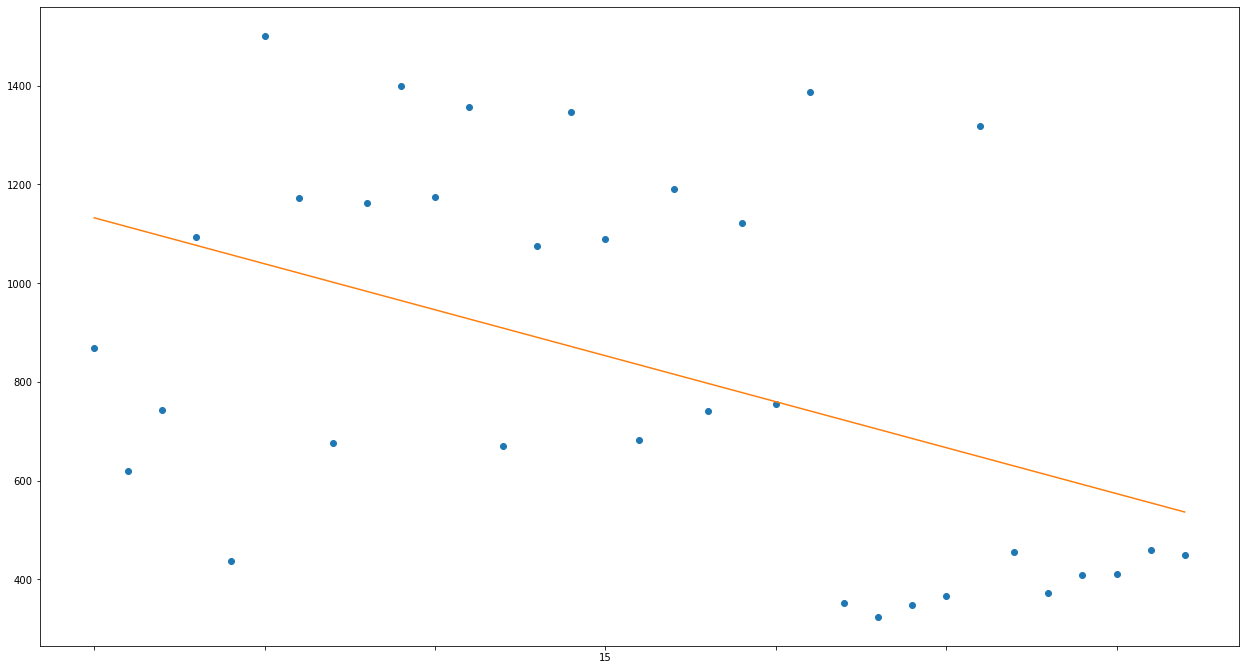

In [4]:
fig, d1 = plt.subplots(1, 1, sharey=True)
x, y, a, b = ReigonTypeQuarterSelector('S08000017', 'All Cancer Types', '2020Q2')

d1.plot(x.index, y, 'o')

XI = np.array(x.index)
XI = XI.reshape((-1, 1))

reg = LinearRegression().fit(XI, y)

print('coefficient of determination:', reg.score(XI, y))
print('intercept:', reg.intercept_)
print('slope:', reg.coef_)
y_pred = reg.predict(XI)
print('predicted response:', y_pred, sep='\n')

every_nth = 4
for n, label in enumerate(d1.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        

m, b = np.polyfit(x.index, y, 1)
plt.plot(x.index, m*x.index + b)

fig.set_size_inches(18.5, 10.5, forward=True)
fig.tight_layout(pad=5.0) 
plt.show()

I think from running a few variants of the above that we see the data is in no way linear. It does seem to be like there's less referalls overall though. Next I believe it is necessary to see whether time series methods can be deployed

---------------------------

## Time Series Analysis

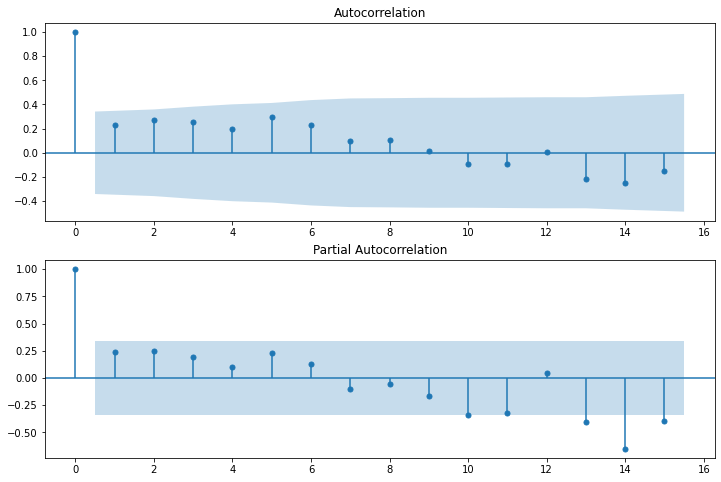

In [5]:
x, y, a, b = ReigonTypeQuarterSelector('S08000017', 'All Cancer Types', '2020Q2')
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y.values.squeeze(), lags=15, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y, lags=15, ax=ax2)

The trouble with the above is that there isn't an obvious cut-off on the lag in the AR component, but it does seem about lag 13 makes sense to cut off for the MA part. Therefore we try an ARIMA(0, 0, 13) model.

/home/s2227580/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


const       828.401231
ma.L1         0.001363
ma.L2         0.308467
ma.L3         0.111926
ma.L4        -0.026736
ma.L5         0.380712
ma.L6         0.313414
ma.L7         0.294128
ma.L8         0.430507
ma.L9         0.045399
ma.L10        0.017881
ma.L11        0.180663
ma.L12        0.476350
ma.L13       -0.016881
sigma2    70197.336391
dtype: float64
499.44625577448653 521.8938691964837 506.9991946967172


/home/s2227580/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


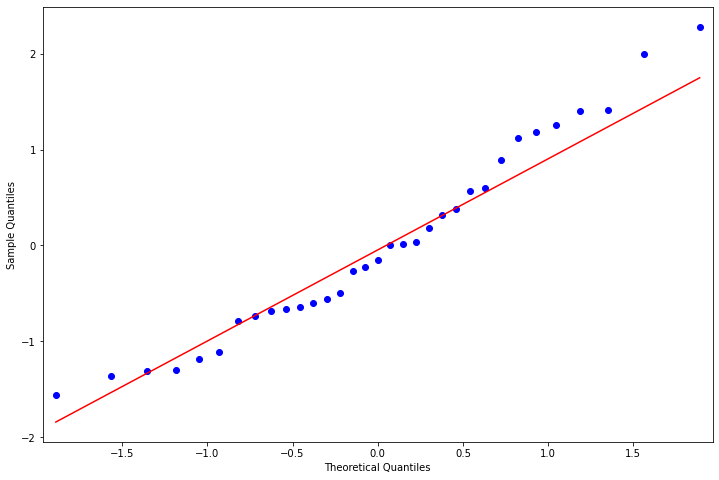

In [6]:
arma_mod20 = ARIMA(y, order=(0, 0, 13)).fit()
print(arma_mod20.params)
print(arma_mod20.aic, arma_mod20.bic, arma_mod20.hqic)

resid = arma_mod20.resid
stats.normaltest(resid)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
fig = qqplot(resid, line="q", ax=ax, fit=True)

The above does seem to suggest this isn't a terrible model - certainly better than that of any form of linear regression.

Does this mean that we can model our waiting times data by a time-series model?

How does this actually help us when it comes to seeing whether there's a significant change?

# Addition
by Sofie Verhees

This part also looks at the health board that refers the patients. However, this part looks at the 62-day standard for all cancer types for all regions separately and together. Instead of splitting pre- and post pandemic, this part just indicates where the pandemic started.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
fullData_31 = pd.read_csv("31DayData.csv")
myData_31 = fullData_31[['Quarter', 'HB', 'HBT', 'CancerType','NumberOfEligibleReferrals31DayStandard','NumberOfEligibleReferralsTreatedWithin31Days']]

fullData_62 = pd.read_csv("62DayData.csv")
myData_62 = fullData_62[['Quarter', 'HB', 'HBT', 'CancerType','NumberOfEligibleReferrals62DayStandard','NumberOfEligibleReferralsTreatedWithin62Days']]

In [8]:
def ReigonTypeQuarterSelector_edit(myData, reigonCode, cancerType, rows):
    typeData = myData[myData['CancerType']== cancerType]
    typeData.to_csv('typeData')
    noaddedData = typeData[typeData['HB'] != 'S92000003']
    noaddedData.to_csv('noaddedData')
    reigonalData = noaddedData[noaddedData['HBT'] == reigonCode]
    reigonalData.to_csv('regionalData')
    
    aggregation_functions = {'Quarter':'first','HBT': 'first', 'CancerType': 'first', rows[0]: 'sum', rows[1]: 'sum'}
    reigonalData = reigonalData.groupby(reigonalData['Quarter'], as_index=False).aggregate(aggregation_functions)
    
    reigonalData.to_csv('finalData')
    
    x = reigonalData["Quarter"]
    y = reigonalData[rows[0]]
    y2 = reigonalData[rows[1]]
    
    return x, y, y2

In [9]:
def ReigonTypeQuarterSelector(myData, reigonCode, cancerType, rows):
    typeData = myData[myData['CancerType']== cancerType]
    reigonalData = typeData[typeData['HB'] == reigonCode]
    
    aggregation_functions = {'Quarter':'first', 'HB': 'first', 'CancerType': 'first', rows[0]: 'sum', rows[1]: 'sum'}
    reigonalData = reigonalData.groupby(reigonalData['Quarter'], as_index=False).aggregate(aggregation_functions)

    x = reigonalData["Quarter"]
    y = reigonalData[rows[0]]
    y2 = reigonalData[rows[1]]
    
    return x, y, y2

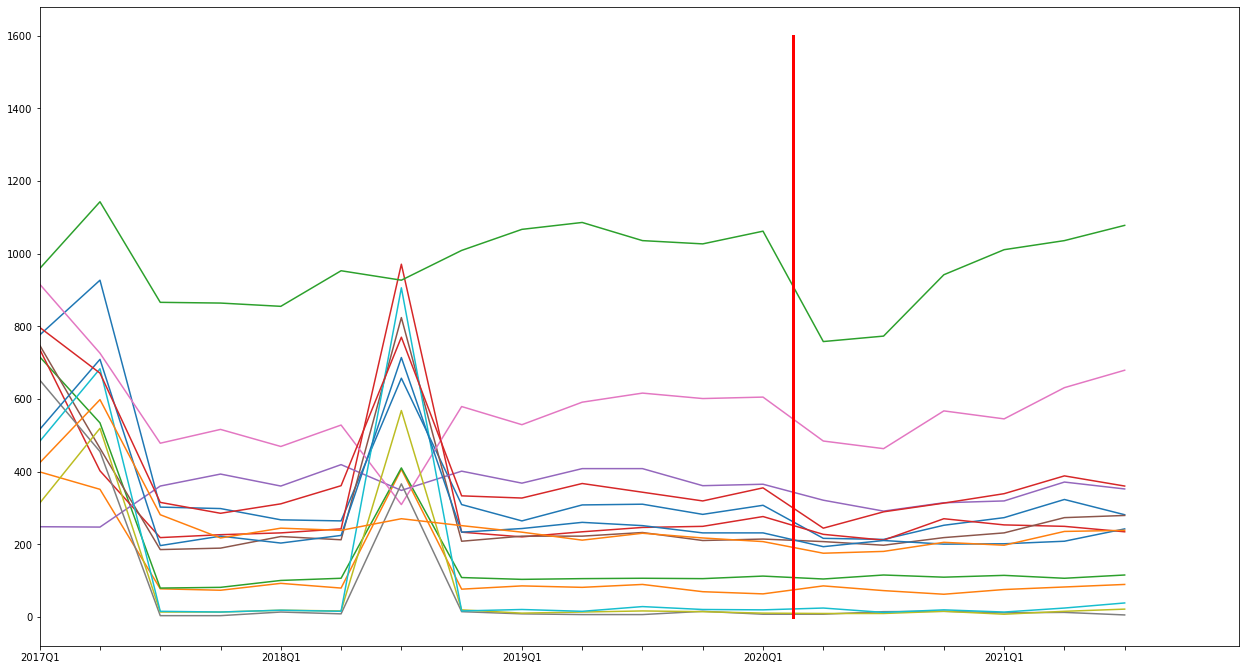

In [10]:
Reigons = ['S08000015', 'S08000016', 'S08000017', 'S08000019', 'S08000020', 'S08000022', 'S08000024', 'S08000025', 'S08000026', 'S08000028', 'S08000029', 'S08000030', 'S08000031', 'S08000032']

fig, d1 = plt.subplots(1, 1, sharey=True)

for i in Reigons:
    x, y, y2 = ReigonTypeQuarterSelector(myData_62, i, 'All Cancer Types', ['NumberOfEligibleReferrals62DayStandard','NumberOfEligibleReferralsTreatedWithin62Days'])
    d1.plot(x, y)

d1.plot([32.5,32.5], [0,1600], color='r', linewidth=3)

every_nth = 4
for n, label in enumerate(d1.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        
d1.set_xlim(left=20)

fig.set_size_inches(18.5, 10.5, forward=True)
fig.tight_layout(pad=5.0) 
plt.show()

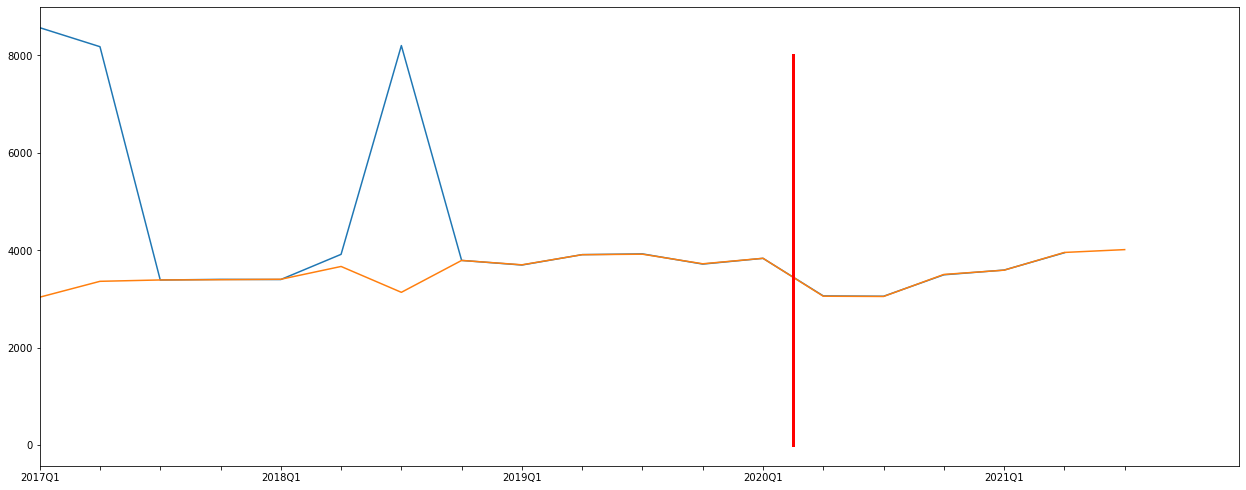

In [11]:
Reigons = ['SB0801', 'S08000015', 'S08000016', 'S08000017', 'S08000019', 'S08000020', 'S08000022', 'S08000024', 'S08000025', 'S08000026', 'S08000028', 'S08000029', 'S08000030', 'S08000031', 'S08000032']
# note that also add together SB0801, otherwise S92000003 adds more together than this one

fig, d1 = plt.subplots(1, 1, sharey=True)
all_regions = 0

for i in Reigons:
    x, y, y2 = ReigonTypeQuarterSelector_edit(myData_62, i, 'All Cancer Types', ['NumberOfEligibleReferrals62DayStandard','NumberOfEligibleReferralsTreatedWithin62Days'])
    all_regions += y

d1.plot(x, all_regions)
    
x, y, y2 = ReigonTypeQuarterSelector(myData_62, 'S92000003', 'All Cancer Types', ['NumberOfEligibleReferrals62DayStandard','NumberOfEligibleReferralsTreatedWithin62Days'])
d1.plot(x, y)


d1.plot([32.5,32.5], [0,8000], color='r', linewidth=3)

every_nth = 4
for n, label in enumerate(d1.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

d1.set_xlim(left=20)
        
fig.set_size_inches(18.5, 8, forward=True)
fig.tight_layout(pad=5.0) 
plt.show()

This seems to be almost the same as in the latest report from PHS about cancer waiting times (https://publichealthscotland.scot/media/10777/2021-12-14-cwt-report.pdf), except for 2018 Q3, not sure if this has been changed since the report came out, december 2021, or if there is a difference somewhere.

Now let's look at the number of treated patients normalized by the number of eligible patients:

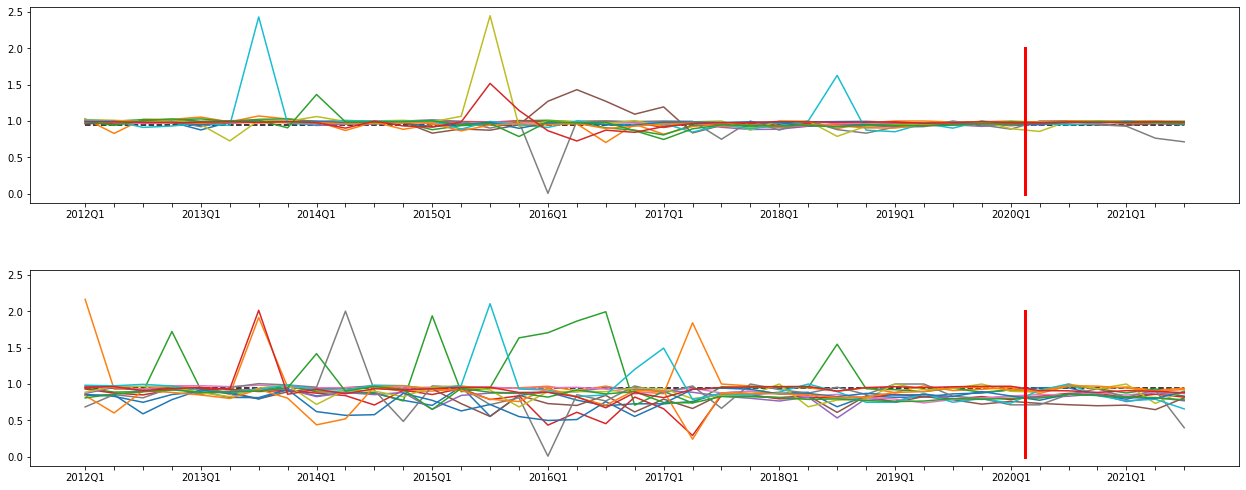

In [12]:
Reigons = ['S08000015', 'S08000016', 'S08000017', 'S08000019', 'S08000020', 'S08000022', 'S08000024', 'S08000025', 'S08000026', 'S08000028', 'S08000029', 'S08000030', 'S08000031', 'S08000032']

fig, (d1, d2) = plt.subplots(2, 1, sharey=True)

d1.plot([0,38], [0.95,0.95], 'k--')
d2.plot([0,38], [0.95,0.95], 'k--')

for i in Reigons:
    x, y, y2 = ReigonTypeQuarterSelector(myData_31, i, 'All Cancer Types', ['NumberOfEligibleReferrals31DayStandard','NumberOfEligibleReferralsTreatedWithin31Days'])
    d1.plot(x,y2/y) 
    x, y, y2 = ReigonTypeQuarterSelector(myData_62, i, 'All Cancer Types', ['NumberOfEligibleReferrals62DayStandard','NumberOfEligibleReferralsTreatedWithin62Days'])
    d2.plot(x,y2/y) 

d1.plot([32.5,32.5], [0,2], color='r', linewidth=3)
d2.plot([32.5,32.5], [0,2], color='r', linewidth=3)

every_nth = 4
for n, label in enumerate(d1.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(d2.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

fig.set_size_inches(18.5, 8, forward=True)
fig.tight_layout(pad=5.0) 
plt.show()

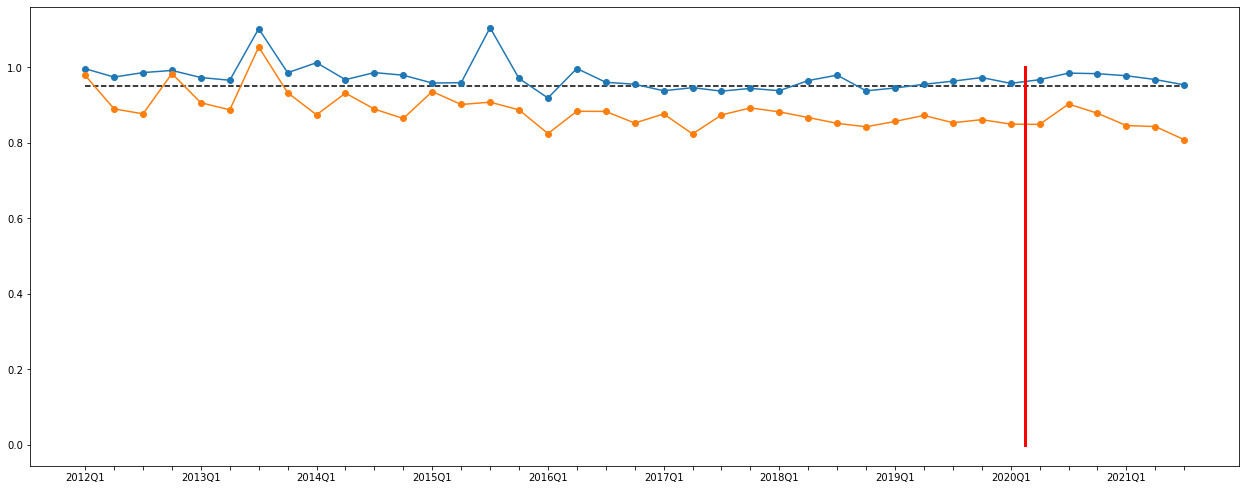

In [13]:
Reigons = ['S08000015', 'S08000016', 'S08000017', 'S08000019', 'S08000020', 'S08000022', 'S08000024', 'S08000025', 'S08000026', 'S08000028', 'S08000029', 'S08000030', 'S08000031', 'S08000032']

fig, d1 = plt.subplots(1, 1, sharey=True)

avg_regions_31 = 0
avg_regions_62 = 0

for i in Reigons:
    x, y, y2 = ReigonTypeQuarterSelector(myData_31, i, 'All Cancer Types', ['NumberOfEligibleReferrals31DayStandard','NumberOfEligibleReferralsTreatedWithin31Days'])
    avg_regions_31 += y2/y
    x, y, y2 = ReigonTypeQuarterSelector(myData_62, i, 'All Cancer Types', ['NumberOfEligibleReferrals62DayStandard','NumberOfEligibleReferralsTreatedWithin62Days'])
    avg_regions_62 += y2/y

d1.plot([0,38], [0.95,0.95], 'k--')

d1.plot(x, avg_regions_31/len(Reigons), 'o-')
d1.plot(x, avg_regions_62/len(Reigons), 'o-')

d1.plot([32.5,32.5], [0,1], color='r', linewidth=3)

every_nth = 4
for n, label in enumerate(d1.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        
fig.set_size_inches(18.5, 8, forward=True)
fig.tight_layout(pad=5.0) 
plt.show()

Again, this looks very much like figure 1 in the PHS latest cancer waiting times report, except for a couple weird outliers. No idea where those come from.

-------------------
# Week 2

For this week we wish to start to investigate:
> Trends in individual cancer types.

> Looking at things in proportion to the population size.

### Graphing Cancer Types

TypeError: ReigonTypeQuarterSelector() missing 1 required positional argument: 'rows'

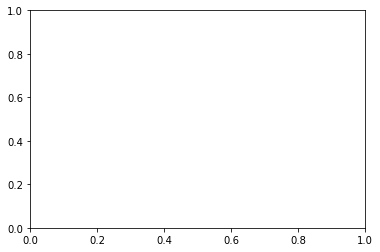

In [14]:
CancerTypes = ['Cervical', 'Lymphoma', 'Melanoma', 'Ovarian', 'Head & Neck', 'Breast', 'Colorectal', 'Upper GI', 'Urological', 'Lung', 'All Cancer Types']

fig, d1 = plt.subplots(1, 1, sharey=True)

for i in CancerTypes:
    x, y, a, b = ReigonTypeQuarterSelector('S08000019', i, '2021Q3')
    d1.plot(x, y, 'o')
    d1.plot(a, b, 'o')

every_nth = 4
for n, label in enumerate(d1.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

plt.axvline(x='2020Q2', color='k', linestyle='-')
#d1.set_xlim(left=24)

fig.set_size_inches(18.5, 10.5, forward=True)
fig.tight_layout(pad=5.0) 
plt.show()

# Super Learner (Example)
Here we will construct a basic example of a super learner.

In [ ]:
from math import sqrt
from numpy import hstack
from numpy import vstack
from numpy import asarray
from sklearn.datasets import make_regression
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

def get_models():
    models = list()
    models.append(LinearRegression())
    models.append(ElasticNet())
    models.append(SVR(gamma='scale'))
    models.append(DecisionTreeRegressor())
    models.append(KNeighborsRegressor())
    models.append(AdaBoostRegressor())
    models.append(BaggingRegressor(n_estimators=10))
    models.append(RandomForestRegressor(n_estimators=10))
    models.append(ExtraTreesRegressor(n_estimators=10))
    return models

# collect out of fold predictions form k-fold cross validation
def get_out_of_fold_predictions(X, y, models):
    meta_X, meta_y = list(), list()
    # define split of data
    kfold = KFold(n_splits=10, shuffle=True)
    # enumerate splits
    for train_ix, test_ix in kfold.split(X):
        fold_yhats = list()
        # get data
        train_X, test_X = X[train_ix], X[test_ix]
        train_y, test_y = y[train_ix], y[test_ix]
        meta_y.extend(test_y)
        # fit and make predictions with each sub-model
        for model in models:
            model.fit(train_X, train_y)
            yhat = model.predict(test_X)
            # store columns
            fold_yhats.append(yhat.reshape(len(yhat),1))
        # store fold yhats as columns
        meta_X.append(hstack(fold_yhats))
    return vstack(meta_X), asarray(meta_y)

# fit all base models on the training dataset
def fit_base_models(X, y, models):
    for model in models:
        model.fit(X, y)

# fit a meta model
def fit_meta_model(X, y):
    model = LinearRegression()
    model.fit(X, y)
    return model

# evaluate a list of models on a dataset
def evaluate_models(X, y, models):
    for model in models:
        yhat = model.predict(X)
        mse = mean_squared_error(y, yhat)
        print('%s: RMSE %.3f' % (model.__class__.__name__, sqrt(mse)))

# make predictions with stacked model
def super_learner_predictions(X, models, meta_model):
    meta_X = list()
    for model in models:
        yhat = model.predict(X)
        meta_X.append(yhat.reshape(len(yhat),1))
    meta_X = hstack(meta_X)
    # predict
    return meta_model.predict(meta_X)

# create the inputs and outputs
X, y = make_regression(n_samples=1000, n_features=100, noise=0.5)
# split
X, X_val, y, y_val = train_test_split(X, y, test_size=0.50)
print('Train', X.shape, y.shape, 'Test', X_val.shape, y_val.shape)
# get models
models = get_models()
# get out of fold predictions
meta_X, meta_y = get_out_of_fold_predictions(X, y, models)
print('Meta ', meta_X.shape, meta_y.shape)
# fit base models
fit_base_models(X, y, models)
# fit the meta model
meta_model = fit_meta_model(meta_X, meta_y)
# evaluate base models
evaluate_models(X_val, y_val, models)
# evaluate meta model
yhat = super_learner_predictions(X_val, models, meta_model)
print('Super Learner: RMSE %.3f' % (sqrt(mean_squared_error(y_val, yhat))))

In [ ]:
# example of a super learner for regression using the mlens library
from math import sqrt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from mlens.ensemble import SuperLearner

# create a list of base-models
def get_models():
	models = list()
	models.append(LinearRegression())
	models.append(ElasticNet())
	models.append(SVR(gamma='scale'))
	models.append(DecisionTreeRegressor())
	models.append(KNeighborsRegressor())
	models.append(AdaBoostRegressor())
	models.append(BaggingRegressor(n_estimators=10))
	models.append(RandomForestRegressor(n_estimators=10))
	models.append(ExtraTreesRegressor(n_estimators=10))
	return models

# cost function for base models
def rmse(yreal, yhat):
	return sqrt(mean_squared_error(yreal, yhat))

# create the super learner
def get_super_learner(X):
	ensemble = SuperLearner(scorer=rmse, folds=10, shuffle=True, sample_size=len(X))
	# add base models
	models = get_models()
	ensemble.add(models)
	# add the meta model
	ensemble.add_meta(LinearRegression())
	return ensemble

# create the inputs and outputs
X, y = make_regression(n_samples=1000, n_features=100, noise=0.5)
# split
X, X_val, y, y_val = train_test_split(X, y, test_size=0.50)
print('Train', X.shape, y.shape, 'Test', X_val.shape, y_val.shape)
# create the super learner
ensemble = get_super_learner(X)
# fit the super learner
ensemble.fit(X, y)
# summarize base learners
print(ensemble.data)
# evaluate meta model
yhat = ensemble.predict(X_val)
print('Super Learner: RMSE %.3f' % (rmse(y_val, yhat)))

In [ ]:
sudo pip install mlens